In [1]:
import sys
import os
import copy
from abc import ABC, abstractmethod
import math
import copy
from copy import deepcopy
import PIL
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import torchvision
import torchvision.models as torchmodels
import torch.nn.functional as F
import openslide
import torch.utils.data

list_pathstoadd = ["../../"]
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
import pydmed
from pydmed.utils.data import *
import pydmed.lightdl
from pydmed.lightdl import *
import pydmed.extensions.wsi
import pydmed.streamcollector

In [2]:
#settings ====
kernel_size = 2000

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#make the model ====
module_resnet = torchvision.models.resnet50()
list_modules = list(module_resnet.children())[0:-2]
model = torch.nn.Sequential(*list_modules)

def func_setpaddingmodes_for_conv2dlayers(module_input, str_paddingmode):
    '''
    Sets the padding mode of all conv2d modules, either on imediate children or non-imediate children.
    '''
    #get num_children
    num_children = 0
    for child in module_input.children():
        num_children += 1
    
    #base case, the module has no children ====
    if(num_children == 0):
        if(isinstance(module_input, torch.nn.Conv2d)):
            module_input.padding_mode = str_paddingmode
        return module_input
        
    #non-base case, loop over children ====
    for child in module_input.children():
        func_setpaddingmodes_for_conv2dlayers(child, str_paddingmode)
    return module_input

model = func_setpaddingmodes_for_conv2dlayers(model, "reflect") #set paddingmode to "reflect"

In [5]:
#make dataset ===================
rootdir = "../../NonGit/Data/Sample3Heatmap/"
list_relativedirs = ["1.tif", "2.tif", "3.tif", "4.tif", "5.tif",\
                     "6.tif", "7.tif", "8.tif", "9.tif", "10.tif"]
list_relativedirs.sort()
#make a list of patients
list_patients = []
for fname in list_relativedirs:
    new_patient = Patient(\
            int_uniqueid = list_relativedirs.index(fname),
            dict_records = {
                "H&E":Record(rootdir, fname, {"resolution":"40x"}),
                "somelabel": np.random.randint(0,4)
             }
         )
    list_patients.append(new_patient)
#make the dataset
dataset = pydmed.utils.data.Dataset("dataset_sample3Heatmap", list_patients)

In [6]:
def func_patient_to_fnameimage(patient_input):
    fname_wsi = os.path.join(
            patient_input.dict_records["H&E"].rootdir,
            patient_input.dict_records["H&E"].relativedir
          )
    return fname_wsi

In [7]:
tfms_onsmallchunkcollection =\
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),\
        torchvision.transforms.ToTensor(),\
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],\
                                         std=[0.229, 0.224, 0.225])
    ])
tfms_oncolate = torchvision.transforms.ToTensor()
const_global_info = {
    "attention_levelidx":1,
    "num_bigchunkloaders":5,
    "maxlength_queue_smallchunk":np.inf,
    "maxlength_queue_lightdl":np.inf,
    "interval_resched": 2,
    "core-assignment":{
                "lightdl":None,
                "smallchunkloaders":None,
                "bigchunkloaders":None
              }
    }

In [8]:
dl_forheatmap = pydmed.extensions.wsi.SlidingWindowDL(
          intorfunc_opslevel = 1,
          kernel_size = kernel_size,
          func_patient_to_fnameimage = func_patient_to_fnameimage,
          stride = kernel_size,
          mininterval_loadnewbigchunk = 15,
          dataset = dataset,\
          type_bigchunkloader=pydmed.extensions.wsi.SlidingWindowBigChunkLoader,\
          type_smallchunkcollector=pydmed.extensions.wsi.SlidingWindowSmallChunkCollector,\
          const_global_info=const_global_info,\
          batch_size=1,\
          tfms_onsmallchunkcollection=tfms_onsmallchunkcollection,\
          tfms = tfms_oncolate,
          flag_grabqueue_onunsched = True
    )

In [9]:
import pydmed.streamcollector
from pydmed.streamcollector import *

class HeatmapStreamCollector(StreamCollector):
    def __init__(self, module_pipeline, device, *args, **kwargs):
        #grab privates
        self.module_pipeline = module_pipeline
        self.device = device
        #make other initial operations
        self.module_pipeline.to(device)
        self.module_pipeline.eval()
        self.num_calls_to_getflagfinished = 0
        super(HeatmapStreamCollector, self).__init__(*args, **kwargs)
        
        
    @abstractmethod
    def process_pieceofstream(self, retval_collatefunc):
        x, list_patients, list_smallchunks = retval_collatefunc
        with torch.no_grad():
            netout = \
                self.module_pipeline(x.to(self.device))#[32x1x7x7]
            list_processedpiece = []
            for n in range(netout.shape[0]):
                stat_n = pydmed.extensions.wsi.Tensor3DtoPdmcsvrow(
                                netout[n,0,:,:].unsqueeze(0), list_smallchunks[n]
                            )
                list_processedpiece.append(
                                   ProcessedPiece(
                                      data = stat_n,\
                                      source_smallchunk = list_smallchunks[n]
                                    )
                                 )
        return list_processedpiece
    
    @abstractmethod
    def get_flag_finishcollecting(self):
        self.num_calls_to_getflagfinished += 1
        is_dl_running = self.lightdl.is_dl_running()
        if((is_dl_running==False) and (self.lightdl.queue_lightdl.qsize()==0)):
            return True
        else:
            return False

In [10]:
statcollector = HeatmapStreamCollector(
                module_pipeline=model,
                device = device,
                lightdl = dl_forheatmap,
                str_collectortype = "stream_to_file",
                flag_visualizestats= False,
                kwargs_streamwriter = {
                    "rootpath": "NonGit/GeneratedHeatmaps/",
                    "fname_tosave":None, 
                    "waiting_time_before_flush":3
                }
            )

In [11]:
statcollector.start_collecting()

 loading initial bigchunks, please wait ....
     bigchunk 0 from 5, please wait ...

     bigchunk 1 from 5, please wait ...

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
     bigchunk 2 from 5, please wait ...

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working 

Please wait. SlidingWindowDL is still working ..... 
extractbigchunk failed for patient utils.data.Patient with unique id: 3.
cannot convert float infinity to integer
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still working ..... 
Please wait. SlidingWindowDL is still 

In [26]:
#TODO:delete transfered to pydmed
def Tensor3DtoPdmcsvrow(np_input, smalchunk_input):
    '''
    Converts a Tensor of shape [C x H x W] to pdmcsv format.
    Inputs.
        - np_input: a numpy array of shape [CxHxW].
        - smallchunk_input: an instnace of SmallChunk,
                            the smallchunk that that the tensor corresponds to.
    '''
    chw = list(np_input.shape)
    str_toret = str([
        smalchunk_input.dict_info_of_bigchunk["y"],\
        smalchunk_input.dict_info_of_smallchunk["x"],\
        smalchunk_input.dict_info_of_bigchunk["H"],\
        smalchunk_input.dict_info_of_bigchunk["W"],\
        smalchunk_input.dict_info_of_smallchunk["patch_levelidx"],\
        smalchunk_input.dict_info_of_smallchunk["kernel_size"],
        smalchunk_input.dict_info_of_bigchunk["downsample_of_patchlevel"],
        chw[0], chw[1], chw[2]
       ])[1:-1]+ "," +\
       str(np_input.flatten().tolist())[1:-1] + "\n"
    return str_toret
    


def pdmcsvtoarray(fname_pdmcsv, func_WSIxyWHval_to_rasterpoints, scale_upsampleraster=1.0):
    '''
    Converts a pdmcsv file to an array.
    Inputs.
        - fname_pdmcsv: a string, the path-filename to the pdmcsv file.
        - outputsize: a float, the scale of output. The default value is 1.0 meaning the output
            array is not scaled.
        - func_WSIxyval_to_rasterpoints: a function.
            - Inputs.
                x: a number, as in one line of the pdm.csv file.
                y: a number, as in one line of the pdm.csv file.
                W: an integer.
                H: an integer.
                val: list of values.
            -Outputs.
                - list_x_onraster:
                - list_y_onraster:
                - list_val_onraster:
    '''
    #read the file line-by-line =====
    file_pdmcsv = open(fname_pdmcsv, 'r')
    count_line = 0
    dict_raster = {}
    while True:
        count_line += 1
        line = file_pdmcsv.readline() 
        
        if not line: 
                break
              
        list_numbers = line.split(",")
        for idx, u in enumerate(list_numbers):
            if(isinstance(list_numbers[idx], str)):
                if("None" in list_numbers[idx]):
                    list_numbers[idx] = np.nan
        list_numbers = [float(u) for u in list_numbers]
        
        if(count_line == 1):
            H, W = list_numbers[2], list_numbers[3]
            H, W = int(H), int(W)
        
        #order: y,x,H,W,....  
        y, x = list_numbers[0], list_numbers[1]
        patch_levelidx = list_numbers[4]
        kernel_size = list_numbers[5]
        downsample_of_patchlevel = list_numbers[6]
        c = int(list_numbers[7])
        h = int(list_numbers[8])
        w = int(list_numbers[9])
        val = list_numbers[10:] #np.mean(np.array([list_numbers[4:]]))
        
        #convert the points to raster space using the function
        list_x_onraster, list_y_onraster, val = func_WSIxyWHval_to_rasterpoints(
                                            x, y, W, H,
                                            patch_levelidx,
                                            kernel_size,
                                            downsample_of_patchlevel,
                                            c, h, w, val
                                        )
        #np_x_onraster, np_y_onraster = np.array(list_x_onraster), np.array(list_y_onraster)
        for idx_rasterpoint in range(len(list_x_onraster)):
            dict_raster["({},{})".format(
                     math.floor(list_x_onraster[idx_rasterpoint]),
                     math.floor(list_y_onraster[idx_rasterpoint])
                    )
                ] = val[idx_rasterpoint]
    
    #convert dict_raster to np.ndarray =====
    list_allrasterx, list_allrastery = [], []
    for u in dict_raster.keys():
        x, y = u[1:-1].split(',')
        x, y = float(x), float(y) 
        if(scale_upsampleraster > 1.0):
            x, y = scale_upsampleraster*x, scale_upsampleraster*y
        x, y = math.floor(x), math.floor(y)
        list_allrasterx.append(x); list_allrastery.append(y)
    list_allrasterx = list(set(list_allrasterx))
    list_allrastery = list(set(list_allrastery))
    list_allrasterx.sort(); list_allrastery.sort()
    max_x, max_y = np.max(list_allrasterx), np.max(list_allrastery)
    output_raster = np.zeros((len(list_allrastery), len(list_allrasterx), c))
    num_totalloops = len(list(dict_raster.keys()))
    count = 0
    for u in dict_raster.keys():
        count += 1
        if((count%10000) == 0):
            print("    >>>>>> Interpolation in progress: point {} out of {}. Please wait .... .".format(count, num_totalloops), end="\r")
        x,y = u[1:-1].split(',')
        x, y = float(x), float(y)
        if(scale_upsampleraster > 1.0):
            x, y = scale_upsampleraster*x, scale_upsampleraster*y
        x, y = math.floor(x), math.floor(y)
        output_raster[list_allrastery.index(y), list_allrasterx.index(x),:] = dict_raster[u]
    #fill-in the zeros if scale_upsample>1.0
    if(scale_upsampleraster > 1.0):
        list_output_scaled = []
        for count_c in range(c):
            f = interp2d(
                np.array(list_allrasterx),
                np.array(list_allrastery),
                output_raster[:,:,count_c], kind='cubic'
            )
            output_raster_scaled_forchannel = f(
                   np.array([j for j in range(max_x)]),
                   np.array([i for i in range(max_y)])
                 )
            list_output_scaled.append(output_raster_scaled_forchannel)
        return np.stack(list_output_scaled, 2)
    return output_raster


class DefaultWSIxyWHvaltoRasterPoints:
    def __init__(self):
        pass
        
    def func_WSIxyWHval_to_rasterpoints(
                self, x, y, W, H,
                patch_levelidx, kernel_size,
                downsample_of_patchlevel,
                c, h, w, val):
        assert(isinstance(val, list))
        assert((c*h*w)== len(val))
        np_val = np.reshape(val, [c,h,w])
        
        size_blockonraster = h #np.sqrt(len(val))
        scale_wsi_to_raster = kernel_size/size_blockonraster
        x_onraster = (x+0.0)/scale_wsi_to_raster
        y_onraster = (y+0.0)/scale_wsi_to_raster
        #make list_x_onraster and list_y_onraster ======
        np_x_onraster = np.array([[j for j in range(int(size_blockonraster))]\
                             for i in range(int(size_blockonraster))]).flatten()+x_onraster
        np_y_onraster = np.array([[i for j in range(int(size_blockonraster))]\
                             for i in range(int(size_blockonraster))]).flatten()+y_onraster
        list_x_onraster = np_x_onraster.tolist()
        list_y_onraster = np_y_onraster.tolist()
        toret_val = []
        for i in range(h):
            for j in range(w):
                toret_val.append(np_val[:,i,j])
        return list_x_onraster, list_y_onraster, toret_val

idx_patient = 0


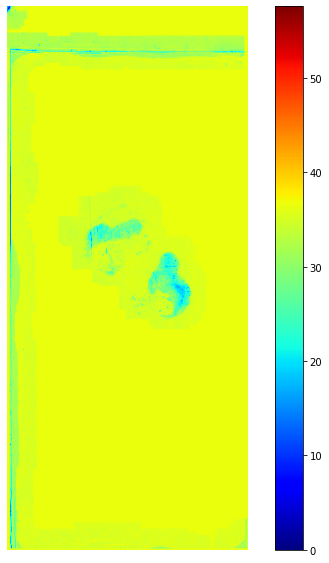



idx_patient = 1


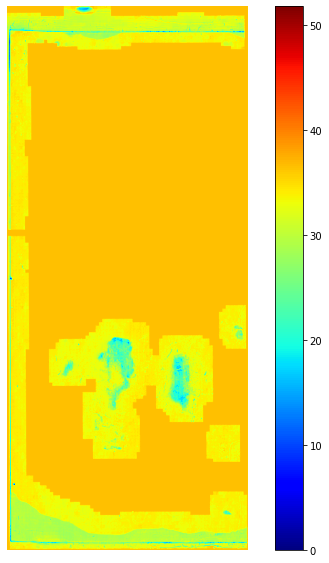



idx_patient = 2


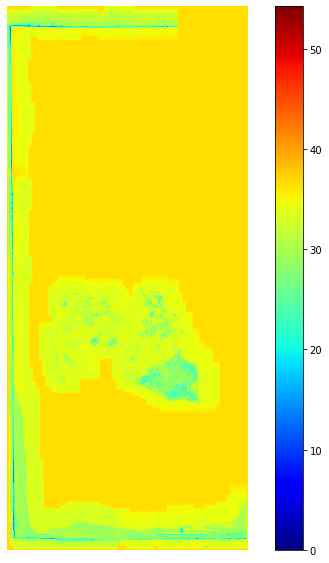



idx_patient = 3


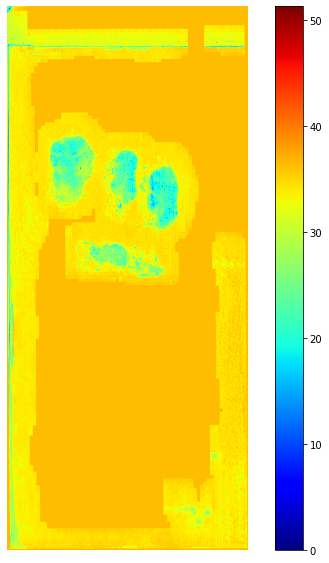



idx_patient = 4


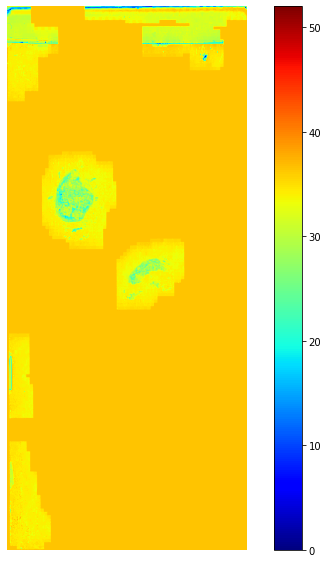



idx_patient = 5


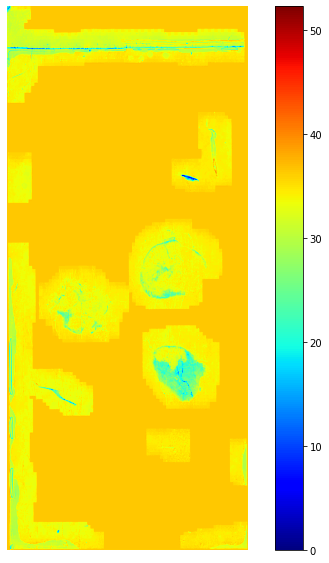



idx_patient = 6


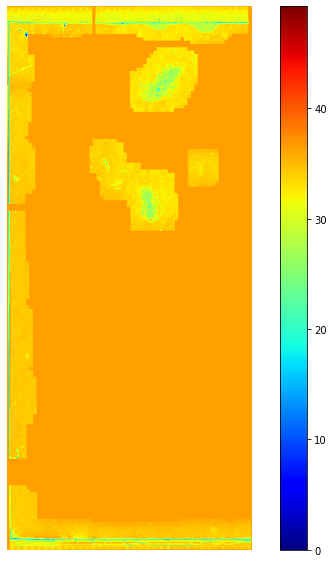



idx_patient = 7


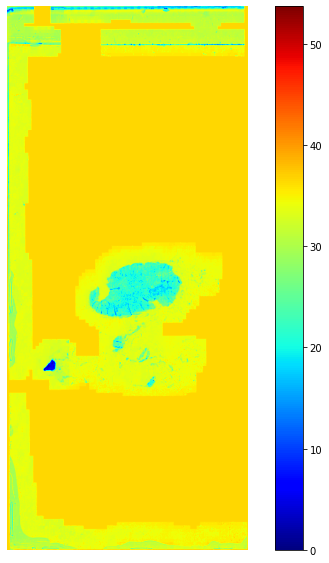



idx_patient = 8


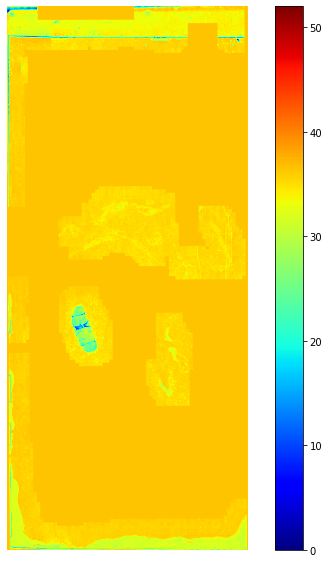



idx_patient = 9


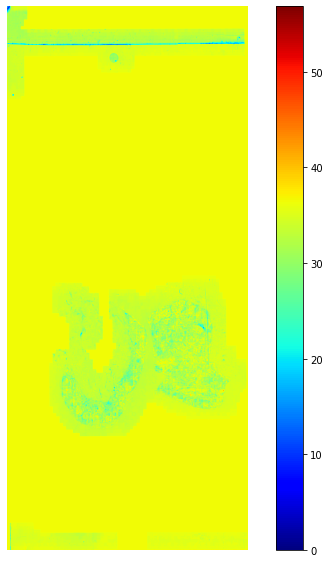

In [28]:
#make the default raster to WSI
default_wsitoraster = DefaultWSIxyWHvaltoRasterPoints()

list_paddedregions = []
for patient in dataset.list_patients:
    print("idx_patient = {}".format(patient.int_uniqueid))
    fname_pdmcsv = "NonGit/GeneratedHeatmaps/patient_{}.csv".format(
                        patient.int_uniqueid
                     )
    np_heatmap = pdmcsvtoarray(
                        fname_pdmcsv,
                        default_wsitoraster.func_WSIxyWHval_to_rasterpoints,
                        scale_upsampleraster = 1.0
                    )
    plt.figure(figsize=(10,10))
    plt.imshow(np_heatmap[:,:,0], cmap="jet")
    plt.colorbar()
    plt.axis("off")
    plt.savefig(
            "NonGit/FromNdarraytoImage/patient_{}.png".format(patient.int_uniqueid),
             dpi=100, pad_inches=0, bbox_inches="tight"
            )
    plt.show()
    
    np.save(
        "NonGit/FromNdarraytoImage/patient_{}".format(patient.int_uniqueid),
         np_heatmap
      )
    print("\n")
    